   y  w  gender_female  gender_male  gender_transgender  ethnicgrp_asian  \
0  1  1              0            1                   0                0   
1  0  0              0            1                   0                0   
2  0  1              0            1                   0                0   
3  0  0              1            0                   0                0   
4  1  1              1            0                   0                1   

   ethnicgrp_black  ethnicgrp_mixed_multiple  ethnicgrp_other  \
0                0                         1                0   
1                0                         0                0   
2                1                         0                0   
3                0                         0                0   
4                0                         0                0   

   ethnicgrp_white  partners1  postlaunch  msm  age  imd_decile  
0                0          0           1    0   27           5  
1                1  

<ipython-input-2-e8feda456b06>:100: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=results_df, x='methods', y='betas', join=False, ci=None)
<ipython-input-2-e8feda456b06>:100: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=results_df, x='methods', y='betas', join=False, ci=None)


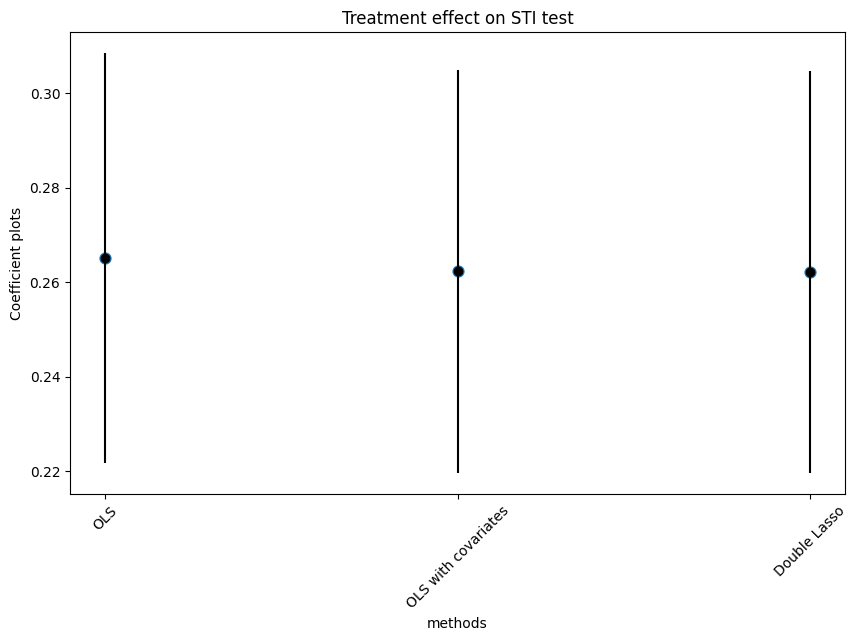

coef (se) = 0.26453778407360395 (0.021795297020113825)
coef (se) = 0.2308610166188085 (0.021482633964887907)
coef (se) = 0.26661419264061553 (0.02105627783915496)
            Method  Coefficient        SE
0            Lasso     0.264538  0.021795
1  Regression Tree     0.230861  0.021483
2   Boosting Trees     0.266614  0.021056


<ipython-input-2-e8feda456b06>:161: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results, x='Method', y='Coefficient', ci=None)


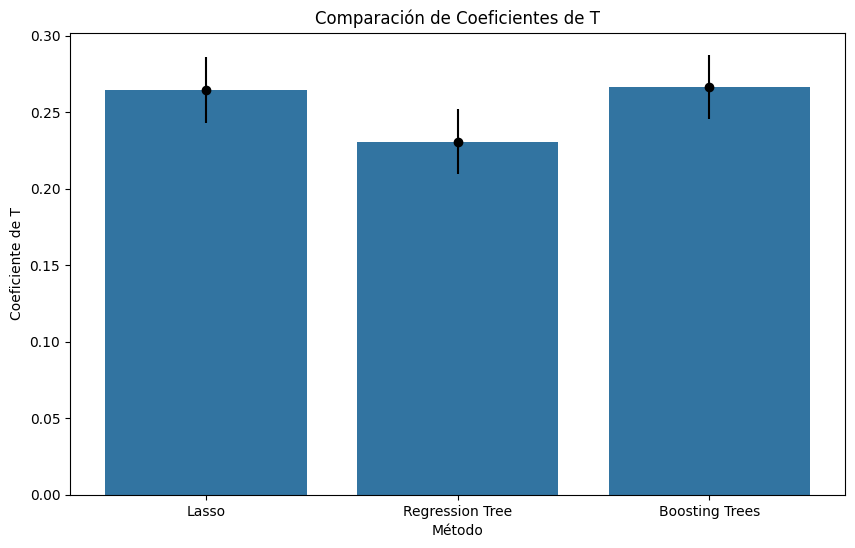

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import seaborn as sns

# Leer los datos
url = "https://raw.githubusercontent.com/gsbDBI/ExperimentData/master/eSTI/processed_data/processed_esti.csv"
data = pd.read_csv(url)
print(data.head())

# Filtrar datos
filtered_data = data[data['gender_transgender'] == 1]
count_transgender = len(filtered_data)

df_treat = data[data['w'] == 1]
df_control = data[data['w'] == 0]

ntreat = len(df_treat)
ncontrol = len(df_control)

varlist_treat = [df_treat['y'], df_treat['gender_male'], df_treat['ethnicgrp_white'], df_treat['partners1'], df_treat['age'], df_treat['imd_decile']]
varlist_control = [df_control['y'], df_control['gender_male'], df_control['ethnicgrp_white'], df_control['partners1'], df_control['age'], df_control['imd_decile']]

table = np.zeros((6, 8))

for i in range(len(varlist_control)):
    # Treated
    table[i, 1] = ntreat
    table[i, 2] = np.mean(varlist_treat[i])
    table[i, 3] = np.std(varlist_treat[i])

    # Control
    table[i, 4] = ncontrol
    table[i, 5] = np.mean(varlist_control[i])
    table[i, 6] = np.std(varlist_control[i])

    # Diff
    table[i, 7] = np.mean(varlist_treat[i]) - np.mean(varlist_control[i])

T = pd.DataFrame({
    'Variables': ["y (any STI test)", "Male (=1 if male)", "White (=1 if white)", "Partners (=1 if person has one partner)", "Age (years)", "Multiple derivation index (decile)"],
    'n(treat)': table[:, 1],
    'Treatmentmean': table[:, 2],
    'sd(treat)': table[:, 3],
    'n(control)': table[:, 4],
    'Controlmean': table[:, 5],
    'sd(control)': table[:, 6],
    'Diff': table[:, 7]
})

print(T)

# Modelos OLS
X = sm.add_constant(data[['w']])
model1 = sm.OLS(data['y'], X).fit()
print(model1.summary())

X = sm.add_constant(data[['w', 'gender_male', 'ethnicgrp_white', 'partners1', 'age', 'imd_decile']])
model2 = sm.OLS(data['y'], X).fit()
print(model2.summary())

# Lasso y Double Lasso
X = data[['gender_male', 'ethnicgrp_white', 'partners1', 'age', 'imd_decile']].values
w = data['w'].values
y = data['y'].values

cv_model3a = LassoCV(cv=5).fit(X, w)
cv_model3b = LassoCV(cv=5).fit(X, y)

model3a = LassoCV(cv=5).fit(X, w)
model3b = LassoCV(cv=5).fit(X, y)

resW = w - model3a.predict(X)
resY = y - model3b.predict(X)

lassodf = pd.DataFrame({'resY': resY, 'resW': resW})

model3 = sm.OLS(lassodf['resY'], sm.add_constant(lassodf['resW'])).fit()
print(model3.summary())

# Resultados
methods = ["OLS", "OLS with covariates", "Double Lasso"]
betas = [model1.params['w'], model2.params['w'], model3.params['resW']]
ll = [model1.conf_int().loc['w'][0], model2.conf_int().loc['w'][0], model3.conf_int().loc['resW'][0]]
ul = [model1.conf_int().loc['w'][1], model2.conf_int().loc['w'][1], model3.conf_int().loc['resW'][1]]

results_df = pd.DataFrame({
    'methods': methods,
    'betas': betas,
    'll': ll,
    'ul': ul
})

plt.figure(figsize=(10, 6))
sns.pointplot(data=results_df, x='methods', y='betas', join=False, ci=None)
plt.errorbar(x=range(len(results_df)), y=results_df['betas'], yerr=[results_df['betas']-results_df['ll'], results_df['ul']-results_df['betas']], fmt='o', color='black')
plt.title('Treatment effect on STI test')
plt.ylabel('Coefficient plots')
plt.xticks(rotation=45)
plt.show()

# Double Machine Learning (DML)
from sklearn.model_selection import KFold

def DML2_for_PLM(X, T, y, dreg, yreg, nfold=2):
    nobs = X.shape[0]
    kf = KFold(n_splits=nfold, shuffle=True)
    ytil = np.empty(nobs)
    dtil = np.empty(nobs)
    for train_index, test_index in kf.split(X):
        dfit = dreg(X[train_index], T[train_index])
        yfit = yreg(X[train_index], y[train_index])

        dtil[test_index] = T[test_index] - dfit.predict(X[test_index])
        ytil[test_index] = y[test_index] - yfit.predict(X[test_index])

    model = sm.OLS(ytil, sm.add_constant(dtil)).fit()
    coef_est = model.params[1]
    se = model.bse[1]
    print(f"coef (se) = {coef_est} ({se})")
    return {'coef_est': coef_est, 'se': se, 'dtil': dtil, 'ytil': ytil}

# Modelos de regresión
def lasso_reg(X, y):
    return LassoCV(cv=5).fit(X, y)

def tree_reg(X, y):
    model = RandomForestRegressor()
    model.fit(X, y)
    return model

def boosting_reg(X, y):
    model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01, max_depth=4, random_state=0)
    model.fit(X, y)
    return model

# DML con Lasso
result_lasso = DML2_for_PLM(X, data['w'], data['y'], lasso_reg, lasso_reg)

# DML con Árbol de Regresión
result_tree = DML2_for_PLM(X, data['w'], data['y'], tree_reg, tree_reg)

# DML con Árboles de Boosting
result_boosting = DML2_for_PLM(X, data['w'], data['y'], boosting_reg, boosting_reg)

# Resultados finales
results = pd.DataFrame({
    'Method': ["Lasso", "Regression Tree", "Boosting Trees"],
    'Coefficient': [result_lasso['coef_est'], result_tree['coef_est'], result_boosting['coef_est']],
    'SE': [result_lasso['se'], result_tree['se'], result_boosting['se']]
})

print(results)

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Method', y='Coefficient', ci=None)
plt.errorbar(x=range(len(results)), y=results['Coefficient'], yerr=results['SE'], fmt='o', color='black')
plt.title('Comparación de Coeficientes de T')
plt.xlabel('Método')
plt.ylabel('Coeficiente de T')
plt.show()